In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, MaxPool2d, Dropout, BatchNorm2d, ReLU, Module
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import os
import cv2
torch.manual_seed(22)

In [2]:
train_data_path = "../../DATASETS/classification_datasets/face_expression_recognation/train"
test_data_path = "../../DATASETS/classification_datasets/face_expression_recognation/validation"
device=torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
epochs=50
learning_rate=3e-4
momentum=0.9
batch_size = 16
num_classes=7

In [3]:
class FaceRecognationDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        super(FaceRecognationDataset, self)
        self.data_path=data_path
        self.transforms=transforms
        self.classes = os.listdir(data_path)

        images_path = []
        labels_dict = {}

        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(data_path, class_name)
            for image_path in os.listdir(class_path):
                image_path = os.path.join(class_path, image_path)
                images_path.append(image_path)
                labels_dict[image_path] = i

        self.images_path_list = images_path
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.images_path_list)

    def __getitem__(self,index):
        image_path = self.images_path_list[index]
        label = self.labels_dict[image_path]
        image = Image.open(image_path).convert("RGB")

        if self.transforms != None:
            image = self.transforms(image)

        return image, label

In [4]:
my_transforms = transforms.Compose([
    transforms.Resize(308),
    transforms.CenterCrop(299),
    transforms.ToTensor()])

In [5]:
train_dataset = FaceRecognationDataset(train_data_path, transforms=my_transforms)
test_dataset = FaceRecognationDataset(test_data_path, transforms=my_transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=2)

In [6]:
print(f"Train set: {len(train_dataset)}")
print(f"Test set: {len(test_dataset)}")

Train set: 28821
Test set: 7066


In [7]:
classes = os.listdir(train_data_path)
dist_dict = {}
for class_name in classes:
    single_class_path = os.path.join(train_data_path, class_name)
    num_files = len(os.listdir(single_class_path))
    dist_dict[class_name] = num_files
dist_dict

{'angry': 3993,
 'happy': 7164,
 'surprise': 3205,
 'sad': 4938,
 'neutral': 4982,
 'disgust': 436,
 'fear': 4103}

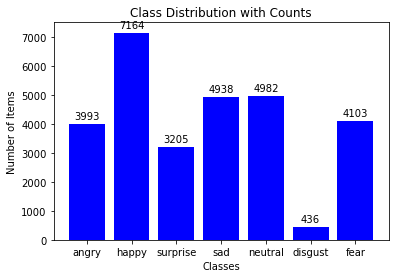

In [8]:
classes = list(dist_dict.keys())
counts = list(dist_dict.values())
fig, ax = plt.subplots()
bars = plt.bar(classes, counts, color='blue')

# Add annotations on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Items')
plt.title('Class Distribution with Counts')
plt.show()

In [9]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act = False, **kwargs):
        super(ConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = act

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        if self.act == True:
            return F.relu(x)
        else: 
            return x

In [10]:
class SeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, act=False):
        super(SeparableConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.act = act

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size = 3, groups=in_channels, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        if self.act == True:
            x = F.relu(x)
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.batchnorm(x)
        return x

In [11]:
class MiddleFlow(nn.Module):
    def __init__(self, channels):
        super(MiddleFlow, self).__init__()
        self.channels = channels

        self.block1 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))
        
        self.block2 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))
        
        self.block3 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))

        self.block4 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))

        self.block5 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))
        
        self.block6 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))

        self.block7 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))
        
        self.block8 = nn.Sequential(
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True),
            SeparableConv(channels, channels, act=True))
    def forward(self, x):
        block1 = self.block1(x)
        fusion1 = x + block1

        block2 = self.block2(fusion1)
        fusion2 = fusion1 + block2

        block3 = self.block3(fusion2)
        fusion3 = fusion2 + block3

        block4 = self.block4(fusion3)
        fusion4 = fusion3 + block4

        block5 = self.block5(fusion4)
        fusion5 = fusion4 + block5

        block6 = self.block6(fusion5)
        fusion6 = fusion5 + block6

        block7 = self.block7(fusion6)
        fusion7 = fusion6 + block7

        block8 = self.block8(fusion7)
        fusion8 = fusion7 + block8

        return fusion8

In [12]:
class Xception(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Xception, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Entry flow
        self.conv1 = ConvBlock(in_channels, 32, kernel_size=3, stride=2, act=True)
        self.conv2 = ConvBlock(32, 64, kernel_size=3, act=True)
        self.residual1 = ConvBlock(64, 128, kernel_size=1, stride=2)

        self.sepconv1 = SeparableConv(64, 128)
        self.sepconv2 = SeparableConv(128, 128, act=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual2 = ConvBlock(128, 256, kernel_size=1, stride=2)

        self.sepconv3 = SeparableConv(128, 256, act=True)
        self.sepconv4 = SeparableConv(256, 256, act=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual3 = ConvBlock(256, 728, kernel_size=1, stride=2)

        self.sepconv5 = SeparableConv(256, 728, act=True)
        self.sepconv6 = SeparableConv(728, 728, act=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Middle flow
        self.middleflow = MiddleFlow(728)

        # Exit Flow
        self.exitsep1 = SeparableConv(728, 728, act=True)
        self.exitsep2 = SeparableConv(728, 1024, act=True)
        self.exitmaxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.exitresidual = ConvBlock(728, 1024, kernel_size=1, stride=2)

        self.exitsep3 = SeparableConv(1024, 1536)
        self.exitsep4 = SeparableConv(1536, 2048)
        self.globalavgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(2048, num_classes)
        

    def forward(self, x):
        # Entry Flow
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        res1 = self.residual1(conv2)
        
        sep1 = self.sepconv1(conv2)
        sep2 = self.sepconv2(sep1)
        pool1 = self.maxpool1(sep2)
        fusion1 = pool1 + res1
        res2 = self.residual2(fusion1)

        sep3 = self.sepconv3(fusion1)
        sep4 = self.sepconv4(sep3)
        pool2 = self.maxpool2(sep4)
        fusion2 = pool2 + res2
        res3 = self.residual3(fusion2)

        sep5 = self.sepconv5(fusion2)
        sep6 = self.sepconv6(sep5)
        pool3 = self.maxpool3(sep6)
        fusion3 = pool3 + res3

        # Middle Flow
        middleflow = self.middleflow(fusion3)

        # Exit Flow
        exitsep1 = self.exitsep1(middleflow)
        exitsep2 = self.exitsep2(exitsep1)
        exitmaxpool = self.exitmaxpool(exitsep2)
        exitresidual = self.exitresidual(middleflow)
        exitfusion = exitresidual + exitmaxpool

        exitsep3 = F.relu(self.exitsep3(exitfusion))
        exitsep4 = F.relu(self.exitsep4(exitsep3))
        globalavgpool = self.globalavgpool(exitsep4)
        dropped = self.dropout(globalavgpool)
        x = torch.flatten(dropped, start_dim=1)
        classifier = self.classifier(x)

        return classifier

In [13]:
model  = Xception(3, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(params=model.parameters(), lr = learning_rate)

In [14]:
# Writing Custom Learning Rate Scheduler 
def adjust_learning_rate(optimizer, epoch, initial_lr, decay_rate):
    # Exponential decay every 10 epochs"
    if epoch % 5 == 0:
        lr = initial_lr * torch.exp(torch.tensor(-decay_rate*epoch))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [15]:
def trainEpoch(device, model, loader, optimizer, criterion):
    loop = tqdm(loader)
    model.train()
    
    losses = []
    correct = 0
    total = 0
    
    for batch_id, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        
        output = model(images)
        
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        batch_correct = (predicted==labels).sum().item()
        batch_acc = 100*batch_correct/labels.size(0)
        correct += batch_correct
        
        loss = criterion(output, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss = loss.item(), train_accuracy = batch_acc)
        
    return np.mean(losses), 100*correct/total

def testEpoch(device, model, loader, criterion):
    model.eval()
    with torch.no_grad():
        losses = []
        correct = 0
        total = 0
        
        loop = tqdm(loader)
        for batch_id, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
            
            output = model(images)
            
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            batch_correct = (predicted==labels).sum().item()
            batch_acc = 100*batch_correct/labels.size(0)
            correct += batch_correct
            
            loss = criterion(output, labels)
            losses.append(loss.item())
            loop.set_postfix(test_loss = loss.item(), test_accuracy = batch_acc)

        return np.mean(losses), 100*correct/total

In [16]:
import copy
last_best = 0
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range (epochs):
    
    train_loss, train_accuracy = trainEpoch(device, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(device, model, test_loader, criterion)
    adjust_learning_rate(optimizer, epoch+1, learning_rate, 0.1)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    # scheduler.step()

    if last_best <= test_accuracy:
        torch.save(copy.deepcopy(model.state_dict()), 'xception.pth')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print(f"Epoch-{epoch+1} Train Loss: {train_losses[-1]:.4f} Train Accuracy: {train_acc[-1]:.4f}")
    print(f"Epoch-{epoch+1} Test Loss: {test_losses[-1]:.4f} Test Accuracy: {test_acc[-1]:.4f}")

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_xception.csv')

100%|██████████| 442/442 [00:24<00:00, 17.94it/s, test_accuracy=60, test_loss=1.1]    


Saving new Best Model!
Epoch-1 Train Loss: 1.4424 Train Accuracy: 43.6695
Epoch-1 Test Loss: 1.3521 Test Accuracy: 49.0943


100%|██████████| 442/442 [00:24<00:00, 18.16it/s, test_accuracy=50, test_loss=1.67]   


Saving new Best Model!
Epoch-2 Train Loss: 1.1966 Train Accuracy: 54.5713
Epoch-2 Test Loss: 1.1260 Test Accuracy: 57.7271


100%|██████████| 442/442 [00:25<00:00, 17.64it/s, test_accuracy=60, test_loss=1.22]   


Saving new Best Model!
Epoch-3 Train Loss: 1.0940 Train Accuracy: 59.1374
Epoch-3 Test Loss: 1.0569 Test Accuracy: 59.9349


100%|██████████| 442/442 [00:24<00:00, 18.14it/s, test_accuracy=60, test_loss=0.917]  


Saving new Best Model!
Epoch-4 Train Loss: 0.9993 Train Accuracy: 62.4961
Epoch-4 Test Loss: 1.0094 Test Accuracy: 62.7371


100%|██████████| 442/442 [00:24<00:00, 18.10it/s, test_accuracy=70, test_loss=0.983]  


Epoch-5 Train Loss: 0.8993 Train Accuracy: 66.5973
Epoch-5 Test Loss: 1.0293 Test Accuracy: 62.3549


100%|██████████| 442/442 [00:24<00:00, 17.92it/s, test_accuracy=70, test_loss=0.756]  


Saving new Best Model!
Epoch-6 Train Loss: 0.6768 Train Accuracy: 75.2646
Epoch-6 Test Loss: 1.0104 Test Accuracy: 65.4967


100%|██████████| 442/442 [00:24<00:00, 17.97it/s, test_accuracy=60, test_loss=1.09]   


Epoch-7 Train Loss: 0.4500 Train Accuracy: 83.9180
Epoch-7 Test Loss: 1.1682 Test Accuracy: 64.0249


100%|██████████| 442/442 [00:24<00:00, 17.77it/s, test_accuracy=60, test_loss=1.15]   


Epoch-8 Train Loss: 0.2413 Train Accuracy: 91.8775
Epoch-8 Test Loss: 1.4533 Test Accuracy: 61.7464


100%|██████████| 442/442 [00:24<00:00, 17.73it/s, test_accuracy=60, test_loss=2.97]   


Epoch-9 Train Loss: 0.1737 Train Accuracy: 94.3618
Epoch-9 Test Loss: 1.5793 Test Accuracy: 63.7843


100%|██████████| 442/442 [00:24<00:00, 18.13it/s, test_accuracy=50, test_loss=2.85]   


Epoch-10 Train Loss: 0.1361 Train Accuracy: 95.7184
Epoch-10 Test Loss: 1.7445 Test Accuracy: 62.7371


100%|██████████| 442/442 [00:25<00:00, 17.43it/s, test_accuracy=80, test_loss=1.6]    


Epoch-11 Train Loss: 0.0715 Train Accuracy: 98.1507
Epoch-11 Test Loss: 1.7154 Test Accuracy: 65.0014


100%|██████████| 442/442 [00:24<00:00, 17.76it/s, test_accuracy=40, test_loss=3.25]   


Epoch-12 Train Loss: 0.0561 Train Accuracy: 98.6191
Epoch-12 Test Loss: 1.8006 Test Accuracy: 64.7042


100%|██████████| 442/442 [00:24<00:00, 18.05it/s, test_accuracy=90, test_loss=0.693]  


Epoch-13 Train Loss: 0.0514 Train Accuracy: 98.6815
Epoch-13 Test Loss: 1.9997 Test Accuracy: 64.2938


100%|██████████| 442/442 [00:24<00:00, 18.28it/s, test_accuracy=40, test_loss=3.09]   


Epoch-14 Train Loss: 0.0485 Train Accuracy: 98.6468
Epoch-14 Test Loss: 2.0104 Test Accuracy: 64.7184


100%|██████████| 442/442 [00:24<00:00, 17.89it/s, test_accuracy=50, test_loss=2.42]   


Epoch-15 Train Loss: 0.0468 Train Accuracy: 98.7232
Epoch-15 Test Loss: 1.9781 Test Accuracy: 64.9165


100%|██████████| 442/442 [00:25<00:00, 17.31it/s, test_accuracy=50, test_loss=2.59]    


Epoch-16 Train Loss: 0.0237 Train Accuracy: 99.3477
Epoch-16 Test Loss: 2.0337 Test Accuracy: 65.0156


 32%|███▏      | 578/1802 [01:28<02:58,  6.86it/s, train_accuracy=100, train_loss=0.0141]  

In [ ]:
train_loss = df["train_loss"]
train_acc = df["train_accuracy"]
valid_loss = df["test_loss"]
valid_acc = df["test_accuracy"]

In [ ]:
plt.plot(train_loss, label="Train loss")
plt.plot(valid_loss, label="Validation loss")
plt.title("Loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(train_acc, label="Train accuracy")
plt.plot(valid_acc, label="Validation accuracy")
plt.title("Accuracy per epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Now, let's load the trained model
model = Xception(in_channels=3, num_classes=7)
model.load_state_dict(torch.load("xception.pth"))

In [ ]:
correct = 0
total = 0
model = model.to(device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
       
        
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model=model.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, true_labels, predicted_labels, nrows, ncols, classes):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        # Convert the tensor image to a NumPy array
        img = images[i]
        img = transforms.ToPILImage()(img)
        true_label = classes[true_labels[i]]
        predicted_label = classes[predicted_labels[i]]

        # Display the image
        ax.imshow(img)

        # Display the label below the image
        if true_label == predicted_label:
            font_color  = "green"
        else:
            font_color = "red"
        ax.set_xlabel(f"GT: {true_label} | Predicted: {predicted_label}", color=font_color)

        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_facecolor("white")

    plt.tight_layout()
    plt.show()

In [ ]:
images, true_labels = next(iter(test_loader))
images = images.to(device)
model = model.to(device)
outputs = model(images)
_, predicted_labels = torch.max(outputs.data, 1)
true_labels = true_labels.numpy()
predicted_labels = predicted_labels.cpu().detach().numpy()

In [ ]:
show_images(images, true_labels, predicted_labels, 4,4, classes)